<a href="https://colab.research.google.com/github/FBRosito/FBRosito/blob/main/MNIST%20Digit%20Classification%20and%20Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow keras

In [ ]:
from keras import datasets, layers, models
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [54]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

model.fit(x=train_images,
          y=train_labels,
          epochs=1,
          validation_data=(test_images, test_labels)
          )

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 39ms/step - accuracy: 0.9000 - loss: 0.3335 - val_accuracy: 0.9811 - val_loss: 0.0567


In [56]:
y_true=test_labels
y_pred=model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


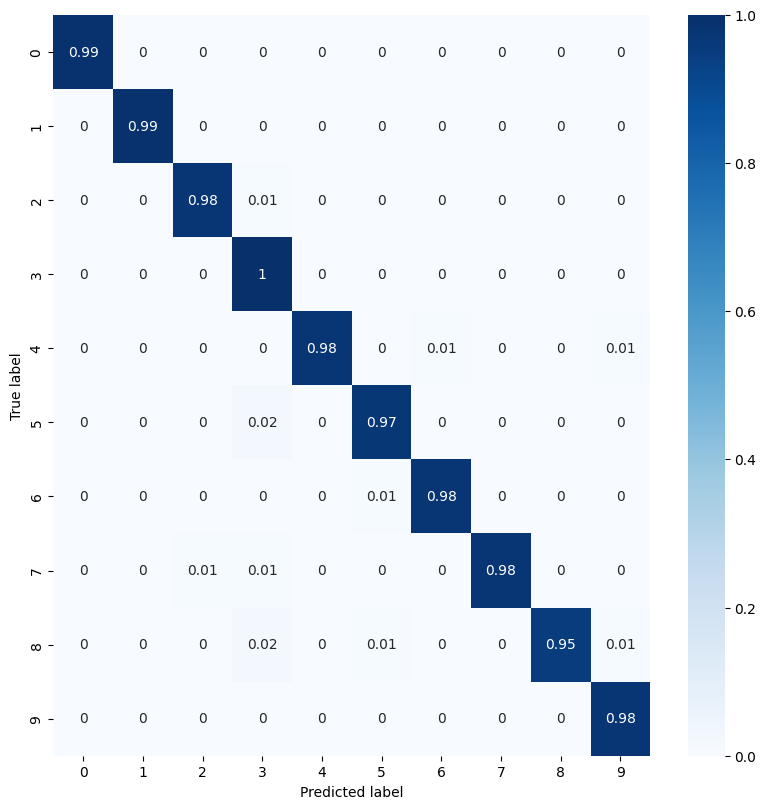

In [57]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

y_pred_classes = np.argmax(y_pred, axis=1)

con_mat = tf.math.confusion_matrix(labels=y_true,predictions=y_pred_classes).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Métricas de Avaliação

Model General Accuracy: 0.9811

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.94      1.00      0.97      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.97      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       1.00      0.95      0.97       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Specificity per class:
Class 0: 0.9984
Class 1: 0.9997
Class 2: 0.9984
Class 3: 0.9925
Class 4: 0.9993
Class 5: 0.9976
Class 6: 0.9985
Class 7: 0.9979
Class 8: 0.9997
Class 9: 0.9970




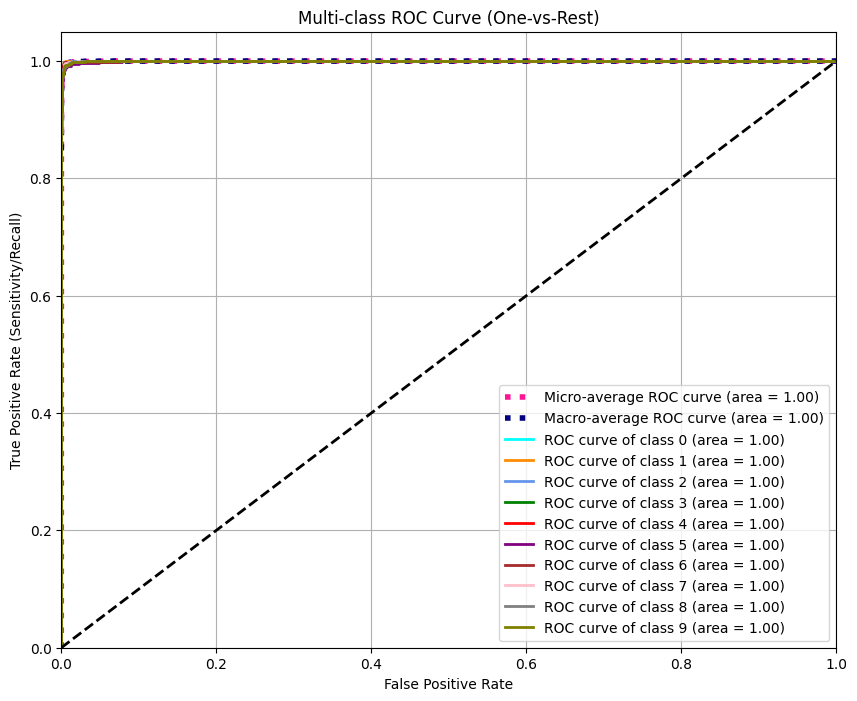


AUC per class:
  Class 0: 0.9999
  Class 1: 0.9999
  Class 2: 0.9999
  Class 3: 0.9999
  Class 4: 0.9999
  Class 5: 0.9996
  Class 6: 0.9999
  Class 7: 0.9999
  Class 8: 0.9998
  Class 9: 0.9998

AUC Micro-average: 0.9998
AUC Macro-average: 0.9999


In [59]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix
)

from sklearn.preprocessing import label_binarize

n_classes = len(classes)

# 1. General Accuracy
accuracy = accuracy_score(test_labels, y_pred_classes)
print(f"Model General Accuracy: {accuracy:.4f}\n")

# 2. Classification report (Precision, Recall/Sensibility, F1-score)

# We need classes to be a list of strings (as labels)
target_names_str = [str(x) for x in classes]

report = classification_report(test_labels, y_pred_classes, target_names=target_names_str)
print("Classification Report:\n", report)

# 3. Specificity per class:
print("Specificity per class:")
for i in range(n_classes):
  tp = con_mat[i, i]
  fp = np.sum(con_mat[:, i]) - tp
  fn = np.sum(con_mat[i, :]) - tp
  tn = con_mat.sum() - (tp + fp + fn)

  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
  print(f"Class {classes[i]}: {specificity:.4f}")
print("\n")

# 4. Roc Curve and AUC for each class (One-vs-Rest)

y_true_binarized = label_binarize(test_labels, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10,8))

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Using a list of distinct colors for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
          'purple', 'brown', 'pink', 'gray', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nAUC per class:")
for i in range(n_classes):
    print(f"  Class {classes[i]}: {roc_auc[i]:.4f}")

print(f"\nAUC Micro-average: {roc_auc['micro']:.4f}")
print(f"AUC Macro-average: {roc_auc['macro']:.4f}")


